In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import unicodedata
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

from prepare import basic_clean, stem, lemmatize, remove_stopwords

In [8]:
df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    # Return a joined string
    return " ".join([wnl.lemmatize(word) for word in words if word not in stopwords])

In [9]:
df.text = df.text.apply(clean)
df.head()

,label,text
id,,
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif oni
2,spam,free entry wkly comp win fa cup final tkts 21s...
3,ham,dun say early hor c already say
4,ham,nah dont think go usf life around though


In [10]:
# We'll use this split function later to create in-sample and out-of-sample datasets for modeling
def split(df, stratify_by=None):
    """
    3 way split for train, validate, and test datasets
    To stratify, send in a column name
    """
    train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df[stratify_by])
    
    train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train[stratify_by])
    
    return train, validate, test

In [11]:
train, validate, test = split(df,'label')
train.head()

,label,text
id,,
236,ham,ill little closer like bus stop street
3851,ham,truekdo knw dis
3906,ham,mean fat head
3365,ham,waiting call sir
2853,ham,haha hope i_ hear receipt sound gd luck


In [13]:
# Setup our X variables
X_train = train.text
X_validate = validate.text
X_test = test.text

In [14]:
# Setup our y variables
y_train = train.label
y_validate = validate.label
y_test = test.label

In [15]:
X_train.head()

id
236      ill little closer like bus stop street
3851                            truekdo knw dis
3906                              mean fat head
3365                           waiting call sir
2853    haha hope i_ hear receipt sound gd luck
Name: text, dtype: object

In [16]:
# Create the tfidf vectorizer object
# Step 1, this creates a tf-idf values for each word, for each document
# Step 2, encodes these values so that we can use models that only work on numbers, like classifications model
tfidf = TfidfVectorizer()

# Fit on the training data
tfidf.fit(X_train)

# Use the object
X_train_vectorized = tfidf.transform(X_train)
X_validate_vectorized = tfidf.transform(X_validate)
X_test_vectorized = tfidf.transform(X_test)

In [17]:
X_train_vectorized.todense().shape

(3119, 6269)

In [49]:
# Now that we have a vectorized dataset, we can use our classification tools!
lm = LogisticRegression(class_weight='balanced',solver='liblinear',random_state=123)

# Fit the classification model on our vectorized train data
lm.fit(X_train_vectorized, y_train)

LogisticRegression(class_weight='balanced', random_state=123,
                   solver='liblinear')

In [50]:
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

In [51]:
train.head()

,actual
id,
236,ham
3851,ham
3906,ham
3365,ham
2853,ham


In [52]:
# Use the trained model to predict y given those vectorized inputs of X
train['predicted'] = lm.predict(X_train_vectorized)
validate["predicted"] = lm.predict(X_validate_vectorized)
test['predicted'] = lm.predict(X_test_vectorized)

In [53]:
train.head()

,actual,predicted
id,,
236,ham,ham
3851,ham,ham
3906,ham,ham
3365,ham,ham
2853,ham,ham


In [54]:
# Train Accuracy
(train.actual == train.predicted).mean()

0.9884578390509778

In [55]:
# Out of sample accuracy
(validate.actual == validate.predicted).mean()

0.9693572496263079

In [56]:
from sklearn.metrics import classification_report
print(classification_report(train.actual, train.predicted))

              precision    recall  f1-score   support

         ham       1.00      0.99      0.99      2701
        spam       0.93      0.99      0.96       418

    accuracy                           0.99      3119
   macro avg       0.96      0.99      0.98      3119
weighted avg       0.99      0.99      0.99      3119



In [57]:
test

,actual,predicted
id,,
4574,ham,ham
2858,ham,ham
2515,ham,ham
3863,ham,ham
3849,ham,ham
...,...,...
942,spam,spam
1934,ham,ham
3891,spam,spam


In [59]:
print(classification_report(validate.actual, validate.predicted))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.98      1158
        spam       0.91      0.86      0.88       180

    accuracy                           0.97      1338
   macro avg       0.94      0.92      0.93      1338
weighted avg       0.97      0.97      0.97      1338



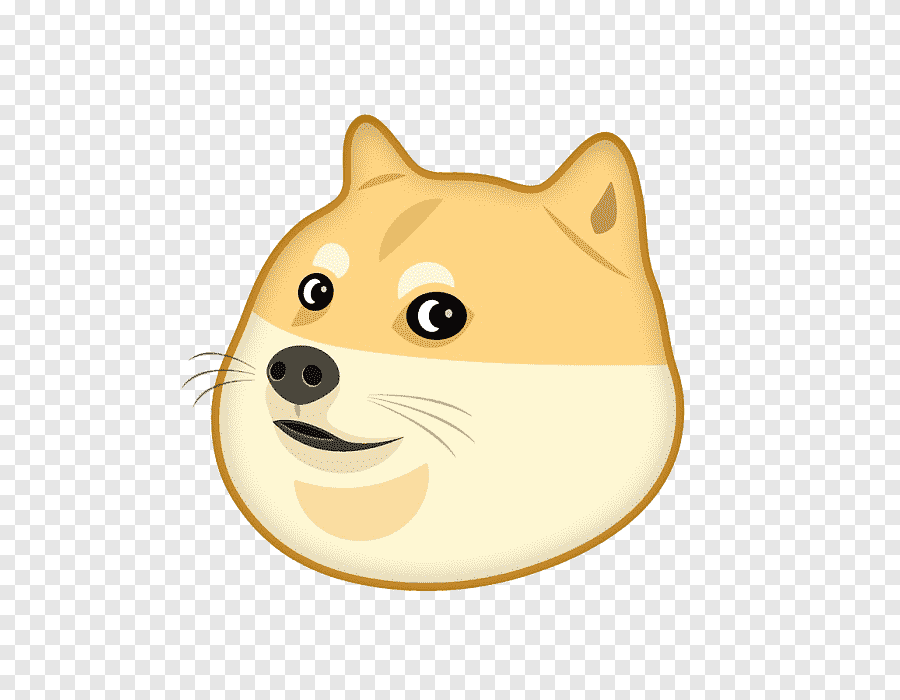

In [63]:
from IPython.display import Image
Image(filename='doge.png',height=200, width=200) 

In [64]:
#VERY ACCURATE, SO RECALL, MUCH WOW
print(classification_report(test.actual, test.predicted))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.92      0.93      0.92       149

    accuracy                           0.98      1115
   macro avg       0.95      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115

